In [3]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from functools import partial
from multiprocessing import Pool
from tqdm.auto import tqdm
from birdclef.utils import cens_per_sec, compute_offset, simple_fast_self

from simple_mp.simple import simple_fast

import IPython.display as ipd

In [4]:
! ls ../data/input/

sample_submission.csv
test.csv
test_soundscapes
train_metadata.csv
train_short_audio
train_soundscape_labels.csv
train_soundscapes


In [5]:
metadata = pd.read_csv("../data/input/train_metadata.csv")
metadata

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,date,filename,license,rating,time,url
0,acafly,['amegfi'],"['begging call', 'call', 'juvenile']",35.3860,-84.1250,Empidonax virescens,Acadian Flycatcher,Mike Nelson,2012-08-12,XC109605.ogg,Creative Commons Attribution-NonCommercial-Sha...,2.5,09:30,https://www.xeno-canto.org/109605
1,acafly,[],['call'],9.1334,-79.6501,Empidonax virescens,Acadian Flycatcher,Allen T. Chartier,2000-12-26,XC11209.ogg,Creative Commons Attribution-NonCommercial-Sha...,3.0,?,https://www.xeno-canto.org/11209
2,acafly,[],['call'],5.7813,-75.7452,Empidonax virescens,Acadian Flycatcher,Sergio Chaparro-Herrera,2012-01-10,XC127032.ogg,Creative Commons Attribution-NonCommercial-Sha...,3.0,15:20,https://www.xeno-canto.org/127032
3,acafly,['whwbec1'],['call'],4.6717,-75.6283,Empidonax virescens,Acadian Flycatcher,Oscar Humberto Marin-Gomez,2009-06-19,XC129974.ogg,Creative Commons Attribution-NonCommercial-Sha...,3.5,07:50,https://www.xeno-canto.org/129974
4,acafly,['whwbec1'],['call'],4.6717,-75.6283,Empidonax virescens,Acadian Flycatcher,Oscar Humberto Marin-Gomez,2009-06-19,XC129981.ogg,Creative Commons Attribution-NonCommercial-Sha...,3.5,07:50,https://www.xeno-canto.org/129981
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62869,yetvir,[],"['adult', 'male', 'song']",30.2150,-97.6505,Vireo flavifrons,Yellow-throated Vireo,Caleb Helsel,2020-07-10,XC591680.ogg,Creative Commons Attribution-NonCommercial-Sha...,1.0,08:30,https://www.xeno-canto.org/591680
62870,yetvir,[],"['life stage uncertain', 'sex uncertain', 'song']",42.3005,-72.5877,Vireo flavifrons,Yellow-throated Vireo,Christopher McPherson,2019-05-31,XC600085.ogg,Creative Commons Attribution-NonCommercial-Sha...,5.0,09:30,https://www.xeno-canto.org/600085
62871,yetvir,"['amered', 'eawpew', 'norcar', 'reevir1']","['adult', 'male', 'song']",42.3005,-72.5877,Vireo flavifrons,Yellow-throated Vireo,Christopher McPherson,2020-06-02,XC602701.ogg,Creative Commons Attribution-NonCommercial-Sha...,4.5,08:30,https://www.xeno-canto.org/602701
62872,yetvir,[],['uncertain'],32.2357,-99.8811,Vireo flavifrons,Yellow-throated Vireo,Brad Banner,2019-04-27,XC614733.ogg,Creative Commons Attribution-NonCommercial-Sha...,4.0,17:30,https://www.xeno-canto.org/614733


In [6]:
species = np.random.choice(metadata.primary_label.unique(), 5)

In [7]:
species

array(['rotbec', 'trokin', 'laufal1', 'mouchi', 'amerob'], dtype=object)

In [8]:
df = None
for sp in species:
    temp = pd.read_pickle(f"../data/cens/train_short_audio/{sp}/data.pkl.gz")
    if df is None:
        df = temp
    else:
        df = pd.concat([df, temp])

In [9]:
metadata["name"] = metadata.filename.apply(lambda x: x.rstrip(".ogg"))
train = df.merge(metadata, on=["name"])[["name", "primary_label", "secondary_labels", "data", "sample_rate"]]
train

,name,primary_label,secondary_labels,data,sample_rate
0,XC127641,rotbec,[],"[2.6425832e-05, 2.1155345e-05, 3.442951e-05, 5...",22050
1,XC181637,rotbec,[],"[-2.9908933e-05, -1.987032e-05, 5.183002e-06, ...",22050
2,XC197076,rotbec,['obnthr1'],"[0.00084980595, 0.0012551339, 0.0011591332, 0....",22050
3,XC197077,rotbec,['obnthr1'],"[0.00063997414, 0.00093738304, 0.00083235244, ...",22050
4,XC197790,rotbec,[],"[0.00015670752, 0.00022534381, 0.00019806823, ...",22050
...,...,...,...,...,...
1230,XC67079,amerob,['grepew'],"[0.00012260402, -1.5144894e-05, 0.0003815506, ...",22050
1231,XC67401,amerob,"['blujay', 'norcar']","[-0.00045652068, -7.902186e-05, 0.00025682402,...",22050
1232,XC70303,amerob,"['norcar', 'tuftit', 'rebwoo', 'amecro', 'bluj...","[-0.0009038505, -0.0012214482, -0.001148847, -...",22050
1233,XC75498,amerob,"['cangoo', 'ribgul', 'rewbla']","[3.9174598e-08, -4.7358423e-08, -1.1442842e-07...",22050


In [10]:
train[train.secondary_labels == "[]"].groupby("primary_label").count()

,name,secondary_labels,data,sample_rate
primary_label,,,,
amerob,279,279,279,279
laufal1,172,172,172,172
mouchi,82,82,82,82
rotbec,16,16,16,16
trokin,196,196,196,196


In [11]:
train = train[train.secondary_labels == "[]"].reset_index()

In [12]:
train

,index,name,primary_label,secondary_labels,data,sample_rate
0,0,XC127641,rotbec,[],"[2.6425832e-05, 2.1155345e-05, 3.442951e-05, 5...",22050
1,1,XC181637,rotbec,[],"[-2.9908933e-05, -1.987032e-05, 5.183002e-06, ...",22050
2,4,XC197790,rotbec,[],"[0.00015670752, 0.00022534381, 0.00019806823, ...",22050
3,5,XC202141,rotbec,[],"[-7.771154e-07, -1.5119283e-06, -1.815999e-06,...",22050
4,7,XC233170,rotbec,[],"[0.0001397171, 0.00020371452, 0.0001773932, 0....",22050
...,...,...,...,...,...,...
740,1222,XC599316,amerob,[],"[-0.0007340358, -0.0011569539, -0.0010969548, ...",22050
741,1223,XC600289,amerob,[],"[-3.1986987e-05, -5.869826e-06, 2.9979388e-05,...",22050
742,1224,XC609728,amerob,[],"[-3.3559725e-05, -2.6947799e-05, -0.0001143361...",22050
743,1227,XC610952,amerob,[],"[0.00035397935, 0.00018700115, 0.00021419756, ...",22050


In [13]:
sample_rate = 22050
convert = partial(
    librosa.feature.chroma_cens,
    hop_length=cens_per_sec(sample_rate, 4),
    n_chroma=36,
    win_len_smooth=None,
)
n = train.shape[0]
with Pool(10) as p:
    conv = list(tqdm(p.imap(convert, train.data), total=n))

  0%|          | 0/745 [00:00<?, ?it/s]

In [14]:
train["conv"] = conv

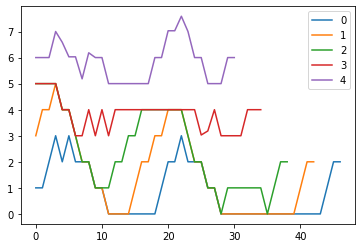

In [15]:
# 3 second window?
for i in range(5):
    mp, pi = simple_fast_self(conv[0], 4*(i+1))
    plt.plot(mp, label=i)
    plt.legend()

In [16]:
window = 4*3
calc_simple = partial(simple_fast_self, window=window)

n = len(conv)
with Pool(10) as p:
    profiles = list(tqdm(p.imap(calc_simple, conv), total=n))
profiles[0]

  0%|          | 0/745 [00:00<?, ?it/s]

(array([5.00000003e+00, 5.00000003e+00, 5.00000003e+00, 5.00000003e+00,
        4.00000003e+00, 4.00000003e+00, 2.99999994e+00, 1.99999994e+00,
        1.99999992e+00, 9.99999920e-01, 9.99999920e-01, 9.99999980e-01,
        1.99999995e+00, 1.99999995e+00, 2.99999989e+00, 2.99999989e+00,
        3.99999994e+00, 3.99999994e+00, 3.99999994e+00, 3.99999994e+00,
        3.99999994e+00, 3.99999994e+00, 3.99999994e+00, 2.99999994e+00,
        2.00000000e+00, 2.00000000e+00, 1.00000006e+00, 1.00000006e+00,
        2.98023222e-08, 9.99999950e-01, 9.99999950e-01, 9.99999970e-01,
        9.99999970e-01, 9.99999970e-01, 9.99999970e-01, 2.98023222e-08,
        1.00000006e+00, 2.00000000e+00, 2.00000000e+00]),
 array([28, 28, 28, 28, 28, 28, 28, 28, 28, 29, 30, 31, 32, 33, 34, 35, 28,
        28, 28, 28, 28, 28, 29, 30, 31, 32, 33, 34, 35,  9, 10, 10,  9, 10,
         9, 28, 29, 30, 31]))

In [17]:
train

,index,name,primary_label,secondary_labels,data,sample_rate,conv
0,0,XC127641,rotbec,[],"[2.6425832e-05, 2.1155345e-05, 3.442951e-05, 5...",22050,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,1,XC181637,rotbec,[],"[-2.9908933e-05, -1.987032e-05, 5.183002e-06, ...",22050,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,4,XC197790,rotbec,[],"[0.00015670752, 0.00022534381, 0.00019806823, ...",22050,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,5,XC202141,rotbec,[],"[-7.771154e-07, -1.5119283e-06, -1.815999e-06,...",22050,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,7,XC233170,rotbec,[],"[0.0001397171, 0.00020371452, 0.0001773932, 0....",22050,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
...,...,...,...,...,...,...,...
740,1222,XC599316,amerob,[],"[-0.0007340358, -0.0011569539, -0.0010969548, ...",22050,"[[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
741,1223,XC600289,amerob,[],"[-3.1986987e-05, -5.869826e-06, 2.9979388e-05,...",22050,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
742,1224,XC609728,amerob,[],"[-3.3559725e-05, -2.6947799e-05, -0.0001143361...",22050,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
743,1227,XC610952,amerob,[],"[0.00035397935, 0.00018700115, 0.00021419756, ...",22050,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [18]:
mps, pis = zip(*profiles)
train["mp"] = pd.Series(mps)
train["pi"] = pd.Series(pis)

In [19]:
train.conv.iloc[0].shape

(36, 50)

In [20]:
conv[2].shape

(36, 50)

In [21]:
mps[2].argmin()+window

34

In [22]:
def get_motif(r, window=4*5, n_bins=36):
    i = r.mp.argmin()
    i = min(i, r.pi[i])
    x = np.zeros(window*n_bins)
    y = r.conv[:, i:i+window].reshape(-1)
    x[:y.shape[0]] = y
    return x

train["snippet_cens"] = train.apply(get_motif, axis=1)
train.snippet_cens

0      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
3      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
4      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
                             ...                        
740    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
741    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6030226945877...
742    [0.0, 0.0, 0.0, 0.0, 0.5773502588272095, 0.0, ...
743    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
744    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: snippet_cens, Length: 745, dtype: object

In [23]:
train.snippet_cens.apply(lambda x: x.shape).unique()

array([(720,)], dtype=object)

In [24]:
import tensorflow as tf

model = tf.keras.models.load_model("../data/models/nocall-detector")

In [25]:
np.stack(train.snippet_cens.values)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [26]:
res = model.predict(np.stack(train.snippet_cens.values)).T[0]

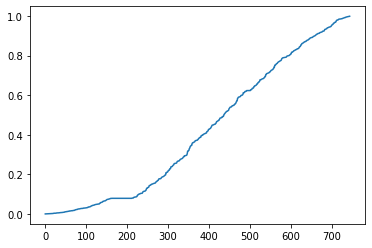

In [27]:
plt.plot(sorted(res))

In [28]:
order = res.argsort()
res[order.argmin()]

0.048051786

In [29]:
train["order"] = res.argsort()

In [30]:
for row in train.sort_values("order", ascending=False).iloc[:10].itertuples():
    print(row.primary_label)
    s0,s1 = compute_offset(row.mp.argmin(), 4*3, row.conv.shape[1], row.data.shape[0])
    ipd.display(ipd.Audio(row.data[s0:s1], rate=row.sample_rate))

laufal1


laufal1


laufal1


laufal1


laufal1


trokin


laufal1


rotbec


rotbec


amerob


In [31]:
for row in train.sort_values("order", ascending=True).head().itertuples():
    s0,s1 = compute_offset(row.mp.argmin(), 4*3, row.conv.shape[1], row.data.shape[0])
    ipd.display(ipd.Audio(row.data[s0:s1], rate=row.sample_rate))

In [32]:
train.snippet_cens

0      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
3      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
4      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
                             ...                        
740    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
741    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6030226945877...
742    [0.0, 0.0, 0.0, 0.0, 0.5773502588272095, 0.0, ...
743    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
744    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: snippet_cens, Length: 745, dtype: object

In [33]:
def mixup(df, alpha=0.4):
    shuf = df.sample(frac=1).reset_index(drop=True)
    x1 = np.stack(df.snippet.values)
    x2 = np.stack(shuf.snippet.values)
    y1 = df.y.values
    y2 = shuf.y.values
    a = np.random.beta(alpha, alpha, (x1.shape[0], 1))
    return (
        a*x1+(1-a)*x2,
        (a.T*y1+(1-a.T)*y2).reshape(-1)
    )

def plot_history(history):
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='test')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.plot(history.history['auc'], label='train')
    plt.plot(history.history['val_auc'], label='test')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend()
    plt.show()

    plt.plot(history.history["loss"], label="train")
    plt.plot(history.history["val_loss"], label="test")
    plt.xlabel("Epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.show()

def get_compiled_model(input_shape=612, output_shape=1):
    n = input_shape
    k = int(np.ceil(np.sqrt(n)))
    rpad = k**2 - n
    model = Sequential()
    model.add(InputLayer(input_shape=input_shape))
    model.add(Reshape((1, n, 1)))
    model.add(ZeroPadding2D(((0, 0), (0, rpad))))
    model.add(Reshape((k, k, 1)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
    model.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(output_shape, activation='sigmoid'))
    
    model.compile(optimizer='adam',
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=['accuracy', AUC(name="auc")])
    return model

In [37]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()

In [38]:
lb.fit_transform(train.primary_label)

array([[0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       ...,
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0]])

In [35]:
X = np.stack(train.snippet_cens.values)